# Determine Jacobinas(DelI for Del TMP) Analytically and Plot Them

# Values Ranges Used in Simulation (New)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.2| 0.6| 5  
Fetal Hb Conc | 11 | 15| 5  
Maternal BVF| 0.2| |    
Fetal BVF| 0.22| |   

# Values Ranges Used in Simulation (old)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.1| 0.6| 5  
Fetal Hb Conc | 0.11 | 0.15| 5  

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.jacobian import (
    FullBloodAnalyticalJC,
    FullBloodJacobianMuAEqn,
    PartialBloodAnalyticalJC,
    PartialBloodJacobianMuAEqn,
    OperatingPoint,
)

# Plotting
FIG_WIDTH = 8
FIG_HEIGHT = 4
plt.style.use("seaborn")
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams["figure.dpi"] = 700  # Paper-ready plots

# Loading Files
maternal_wall_thickness, uterus_thickness, wave_int = 20, 5, 1
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
base_mu_map = MU_MAP_BASE1 if wave_int == 1 else MU_MAP_BASE2

# Create SDD column
raw_sim_data["SDD"] = raw_sim_data["X"] - 100
all_sdd = raw_sim_data["SDD"].unique()
all_sdd.sort()

# Defining Base Parameters 

In [46]:
# Base Parameters
MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
# FETAL_Hb = 0.11
FETAL_Hb = 11.0

# Sweep Parameters
all_fetal_c = np.linspace(11, 16, 6)
# all_fetal_c = np.linspace(0.11, 0.16, 6)
all_fetal_sat = np.linspace(0.1, 0.6, 6)

PLOT_NORMALIZED = True  # Plot the Jacibian divided by Current Intensity (Similar to normalized derivative)

# Jacobian Calculator
mu_a_eqn_old = FullBloodJacobianMuAEqn()    # How the mu_a is calculated for Fetal/Maternal variable layers
# def get_jacobian_calculator(*args, **kwargs):
#     return FullBloodAnalyticalJC(*args, **kwargs)

mu_a_eqn_new = PartialBloodJacobianMuAEqn(0.2, 0.1, 0.75, 0.2, 0.1, 0.75)    # How the mu_a is calculated for Fetal/Maternal variable layers
def get_jacobian_calculator(*args, **kwargs):
    return PartialBloodAnalyticalJC(*args, **kwargs, arterial_volume_fraction=0.1, venous_saturation_reduction_factor=0.75)

# SDD
sdd_indices = np.arange(2, 20, 2) # Which detectors to calculate (2-20, every 2, for Faster plotting)

# Alternate Formula 
(Compare against the analytical expressions)

In [50]:
def calculate_IiLi_fraction(filtered_photon_data: pd.DataFrame, operating_point: OperatingPoint) -> float:
    """
    Calculates the expected value of IiLi(new) / IiLi(old) for a given operating point and filtered_photon_data
    """
    base_mu_map = {1: 0., 2:0, 3:0, 4:0}    # Dummy mu_map
    mu_map_old = mu_a_eqn_old.get_mu_map(base_mu_map, operating_point)
    mu_map_new = mu_a_eqn_new.get_mu_map(base_mu_map, operating_point)
    mu1_old = mu_map_old[1]
    mu1_new = mu_map_new[1]
    mu4_old = mu_map_old[4]
    mu4_new = mu_map_new[4]
    delta_mu1 = mu1_old - mu1_new
    delta_mu4 = mu4_old - mu4_new
    coeff = (1 - 1/delta_mu4)/(delta_mu1 * delta_mu4)
    l1_max = filtered_photon_data["L1 ppath"].max()
    l1_min = filtered_photon_data["L1 ppath"].min()
    l4_max = filtered_photon_data["L4 ppath"].max()
    l4_min = filtered_photon_data["L4 ppath"].min()
    # return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * delta_mu4))
    return coeff * np.exp(l1_min * delta_mu1 + l4_min * delta_mu4)

# Calculating Derivatives Fractions

In [51]:
data_table = pd.DataFrame(columns=["Fetal Saturation", "Fetal Concentration", "Fraction"])

# Comment on Types: 1 & 2 : delI/delFS, 3 & 4 : delI/delFC
# Types 1 & 3: Fetal Sat varies, Types 2 & 4: Fetal Conc varies

# for sdd_index in sdd_indices:
SDD = all_sdd[4]
filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()

# Round 1 - Plots for Varying Fetal Saturation (type 1 & 3)
for fs in all_fetal_sat:
    fs = round(fs, 2)  # np.range sometimes creates weird numbers... round to 2 decimal places
    for fc in all_fetal_c:
        fc = round(fc, 2)  # np.range sometimes creates weird numbers... round to 2 decimal places
        operating_point = OperatingPoint(MATERNAL_Hb, MATERNAL_SAT, fc, fs, wave_int)
        iili_fraction = calculate_IiLi_fraction(filtered_photon_data, operating_point)

        # Adding to Table
        new_row = {
            "Fetal Saturation": fs,
            "Fraction": iili_fraction,
            "Fetal Concentration": fc,
        }
        data_table.loc[len(data_table)] = new_row

/tmp/ipykernel_1194893/3442885632.py:19: RuntimeWarning: overflow encountered in exp
  return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * delta_mu4))
/tmp/ipykernel_1194893/3442885632.py:19: RuntimeWarning: overflow encountered in exp
  return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * delta_mu4))
/tmp/ipykernel_1194893/3442885632.py:19: RuntimeWarning: overflow encountered in exp
  return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * delta_mu4))
/tmp/ipykernel_1194893/3442885632.py:19: RuntimeWarning: overflow encountered in exp
  return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * delta_mu4))
/tmp/ipykernel_1194893/3442885632.py:19: RuntimeWarning: overflow encountered in exp
  return coeff * (np.exp(l1_max * delta_mu1 + l4_max * delta_mu4) - np.exp(l1_min * delta_mu1 + l4_min * de

# Plotting Data

Text(0.5, 1.0, 'Ratio of $\\sum I_i \\times L_i$ between new and old tissue models')

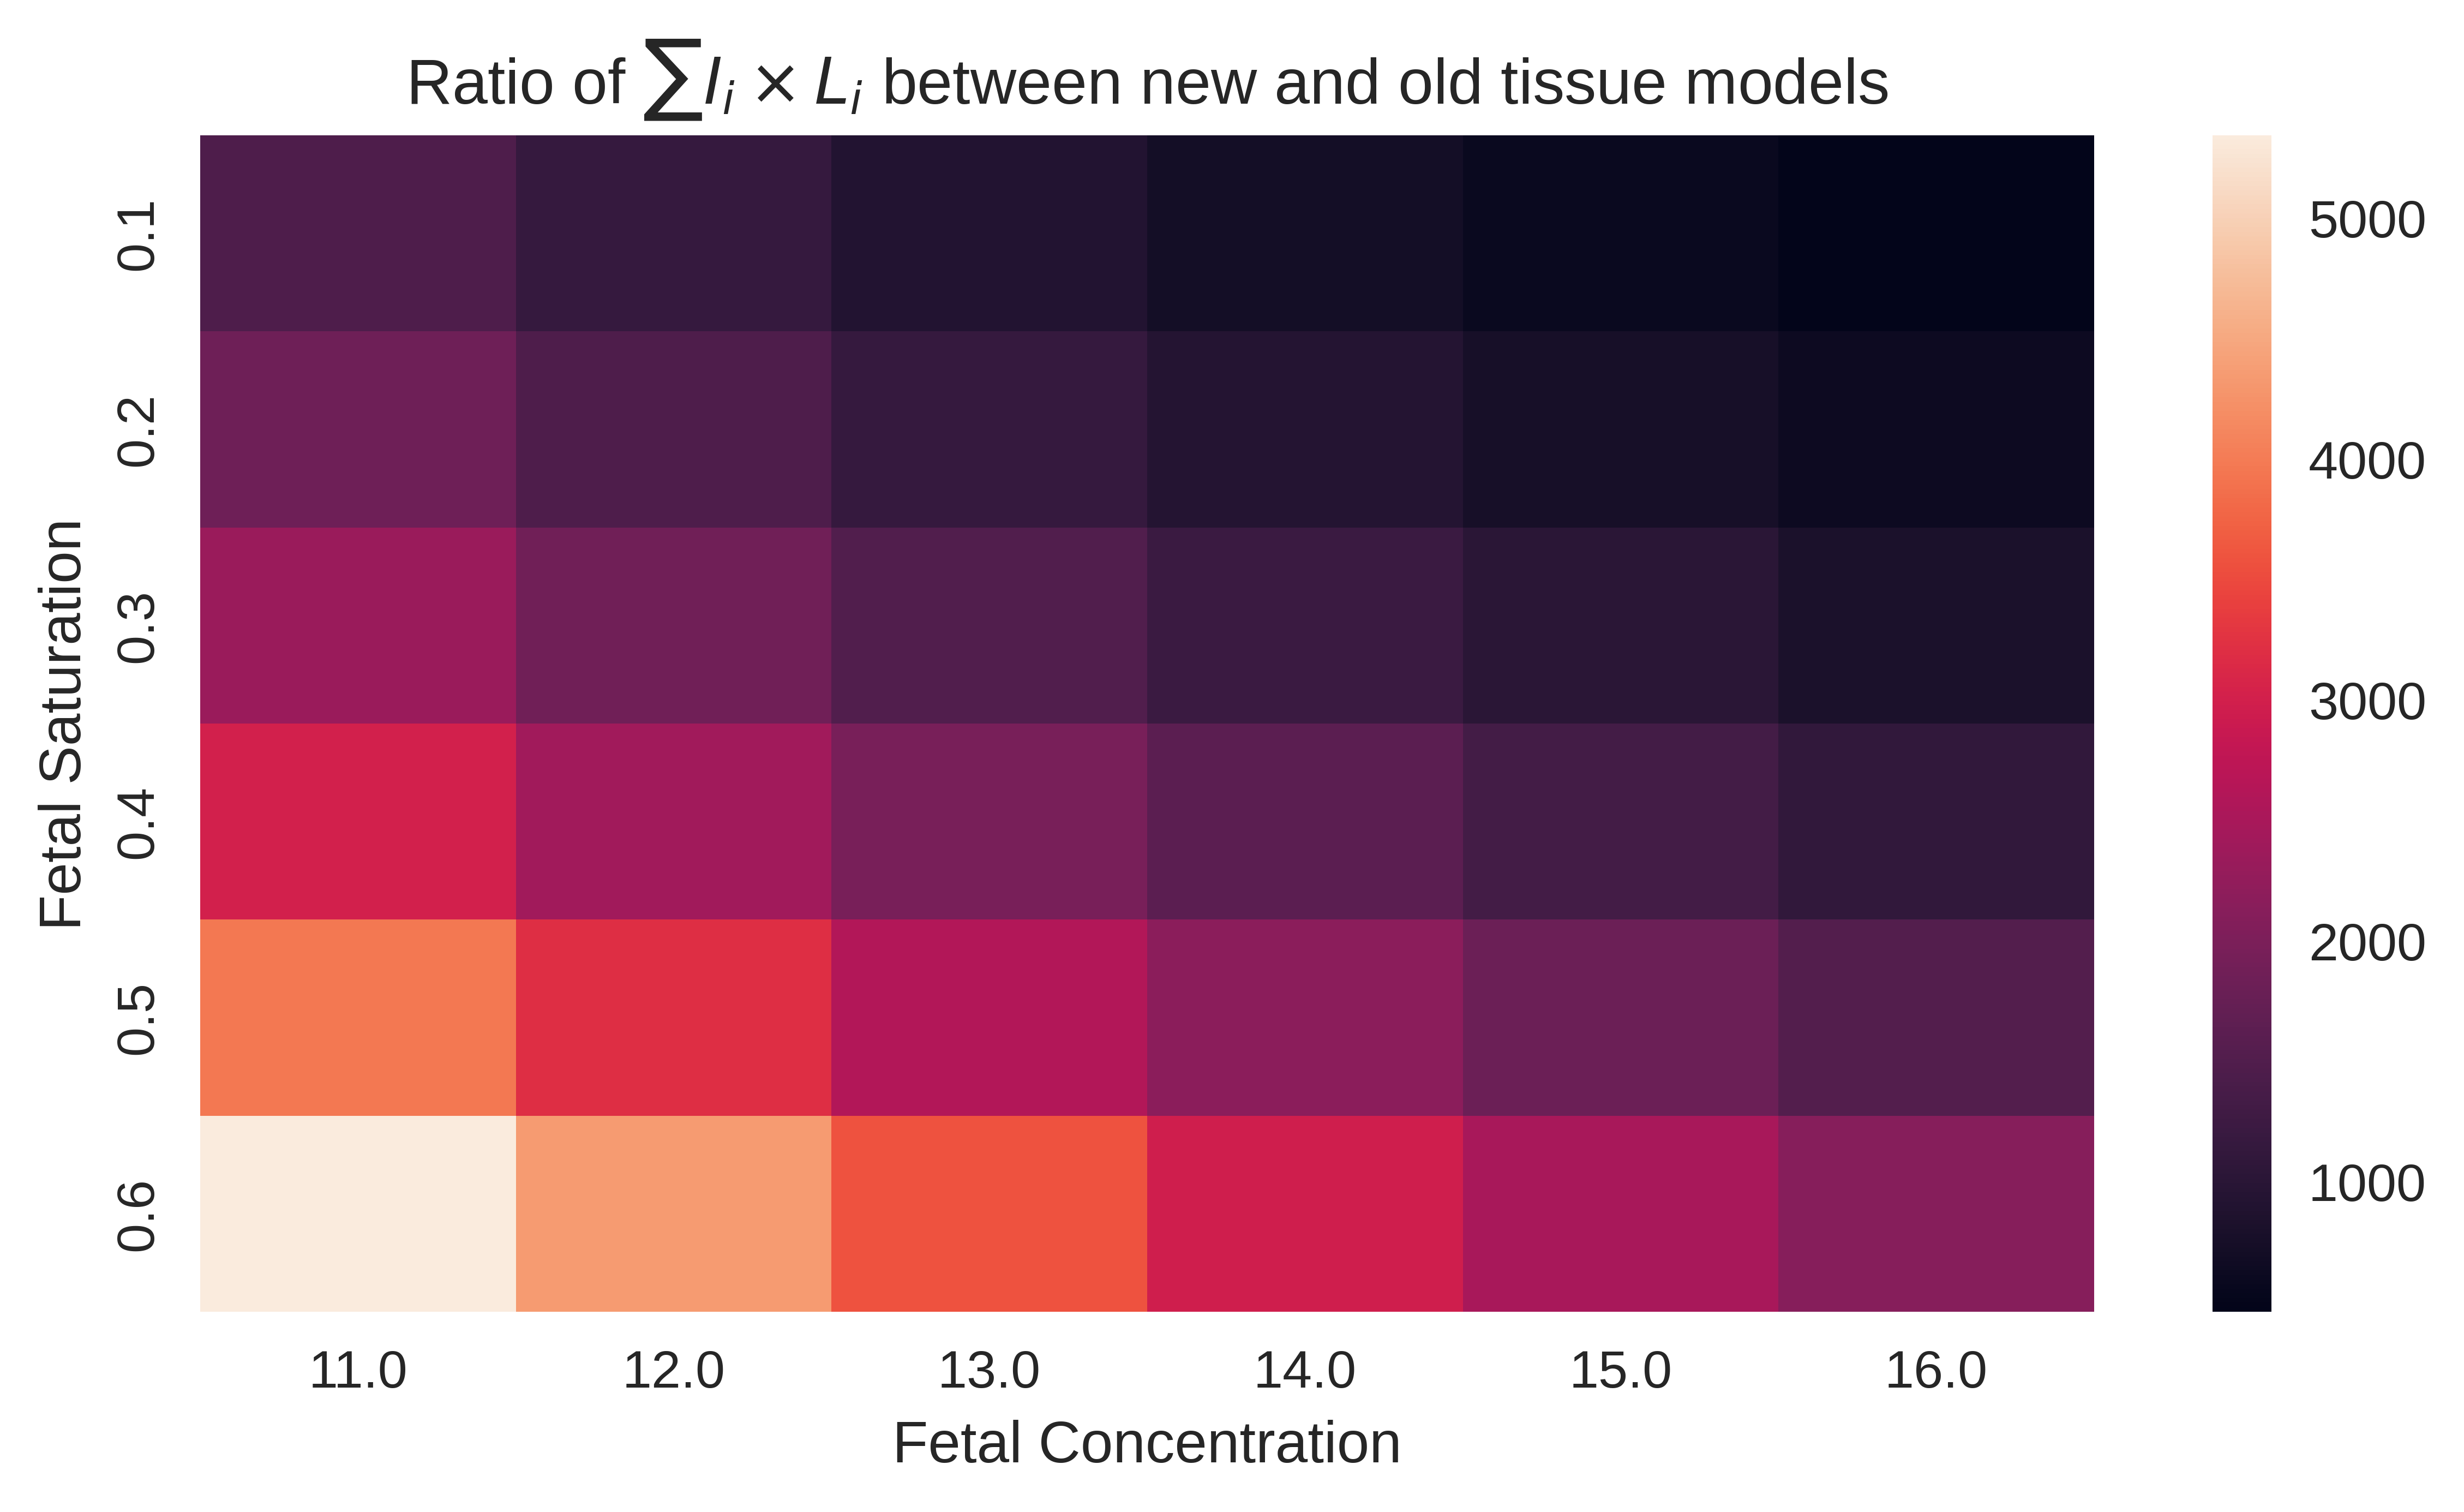

In [49]:
# Mandatory - Make all the derivatives positive
data_table['Fraction'] = data_table['Fraction'].abs()

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
sns.heatmap(data_table.pivot(index='Fetal Saturation', columns='Fetal Concentration', values='Fraction'))
plt.title(r'Ratio of $\sum I_i \times L_i$ between new and old tissue models')